In [1]:
%cd /content/drive/MyDrive/Colab/islampy/

/content/drive/MyDrive/Colab/islampy


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Load Data

In [3]:
data = pd.read_csv('data/muslim_non_muslim.csv')

In [4]:
data.head()

,name,muslim
0,कृष्णमनी झा,0.0
1,पति परमानन्द मंडल,0.0
2,डोमन मंडल,0.0
3,गुनानन्द झा,0.0
4,मुकुन्द लाल झा,0.0


In [5]:
data.shape

(3043736, 2)

In [6]:
data['name'].str.len().max()

30

In [7]:
data.groupby('muslim').count()

,name
muslim,
0.0,2565378
1.0,349603
9.0,128755


In [8]:
data[data['muslim'] == 9.0].head()

,name,muslim
111,ज्ञानी साहु,9.0
200,जसरथ साह,9.0
203,नसरत साह,9.0
443,ठीठरु साह,9.0
494,बगघु साह,9.0


In [9]:
data = data.drop(data[data['muslim'] == 9.0].index)

In [10]:
data.groupby('muslim').count()

,name
muslim,
0.0,2565378
1.0,349603


In [11]:
X = data['name'].values
y = data['muslim'].values

# Split Data

In [12]:
X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size=0.3)

In [13]:
X_train.size

2040486

In [14]:
X_rem.size

874495

In [15]:
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5)

In [16]:
X_val.size

437247

In [17]:
X_test.size

437248

In [21]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, 2)
y_val = to_categorical(y_val, 2)
y_test = to_categorical(y_test, 2)

# Creating Dataset

In [22]:
BATCH_SIZE = 64
BUFFER_SIZE = 2100000

In [23]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(BATCH_SIZE)

In [24]:
text_batch, label_batch = next(iter(train_dataset))
first_name, first_label = text_batch[0], label_batch[0]
print("Name", first_name.numpy().decode())
print("Label", first_label)

Name दुख दवन सीह
Label tf.Tensor([1. 0.], shape=(2,), dtype=float32)


# Vectorization

In [25]:
max_features = 300000
sequence_length = 50

vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [26]:
# Make a text-only dataset (without labels), then call adapt
train_text = train_dataset.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [27]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [28]:
print("Vectorized data", vectorize_text(first_name.numpy().decode(), first_label))

Vectorized data (<tf.Tensor: shape=(1, 50), dtype=int64, numpy=
array([[1355, 3486,  482,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0]])>, <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1., 0.], dtype=float32)>)


In [29]:
print("199512 ---> ",vectorize_layer.get_vocabulary()[199512])
print(" 2 ---> ",vectorize_layer.get_vocabulary()[2])
print(f'Vocabulary size: {len(vectorize_layer.get_vocabulary())}')

199512 --->  सफूअन
 2 --->  यादव
Vocabulary size: 300000


In [30]:
train_ds = train_dataset.map(vectorize_text)
val_ds = val_dataset.map(vectorize_text)
test_ds = test_dataset.map(vectorize_text)

In [31]:
# For performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Model

In [32]:
embedding_dim = 64
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(max_features + 1, embedding_dim),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(2, activation='softmax')])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          19200064  
                                                                 
 dropout (Dropout)           (None, None, 64)          0         
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                                 
Total params: 19,200,194
Trainable params: 19,200,194
Non-trainable params: 0
____________________________________________

In [33]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

In [34]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


31883/31883 [==============================] - 175s 5ms/step - loss: 0.1028 - accuracy: 0.9648 - val_loss: 0.0844 - val_accuracy: 0.9734
Epoch 2/10
31883/31883 [==============================] - 171s 5ms/step - loss: 0.0812 - accuracy: 0.9734 - val_loss: 0.0828 - val_accuracy: 0.9746
Epoch 3/10
31883/31883 [==============================] - 169s 5ms/step - loss: 0.0791 - accuracy: 0.9745 - val_loss: 0.0819 - val_accuracy: 0.9746
Epoch 4/10
31883/31883 [==============================] - 167s 5ms/step - loss: 0.0780 - accuracy: 0.9750 - val_loss: 0.0814 - val_accuracy: 0.9742
Epoch 5/10
31883/31883 [==============================] - 168s 5ms/step - loss: 0.0772 - accuracy: 0.9753 - val_loss: 0.0812 - val_accuracy: 0.9741
Epoch 6/10
31883/31883 [==============================] - 167s 5ms/step - loss: 0.0767 - accuracy: 0.9755 - val_loss: 0.0811 - val_accuracy: 0.9741
Epoch 7/10
31883/31883 [==============================] - 167s 5ms/step - loss: 0.0763 - accuracy: 0.9757 - val_loss: 0.081

# Evaluate

In [35]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

6832/6832 [==============================] - 12s 2ms/step - loss: 0.0810 - accuracy: 0.9741
Loss:  0.08101983368396759
Accuracy:  0.9741314053535461


# Plot

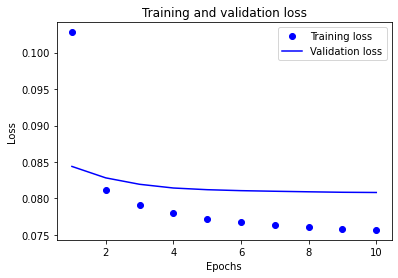

In [36]:
history_dict = history.history
history_dict.keys()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

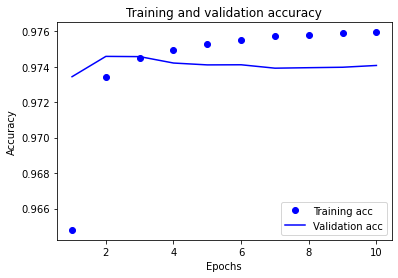

In [37]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

# Save Model

In [38]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model
])

export_model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

loss, accuracy = export_model.evaluate(test_dataset)
print(accuracy)

6832/6832 [==============================] - 15s 2ms/step - loss: 0.0810 - accuracy: 0.9741
0.9741314053535461


In [39]:
export_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 50)               0         
 torization)                                                     
                                                                 
 sequential (Sequential)     (None, 2)                 19200194  
                                                                 
Total params: 19,200,194
Trainable params: 19,200,194
Non-trainable params: 0
_________________________________________________________________


# Inference

In [40]:
examples = [
  "शाहरुख खान",
  "अमिताभ बच्चन",
  "अब्दुल राशिद सलीम सलमान खान"
]

results = export_model.predict(examples)

In [41]:
results

array([[2.78693829e-02, 9.72130597e-01],
       [9.47521925e-01, 5.24780154e-02],
       [1.08974615e-04, 9.99891043e-01]], dtype=float32)

In [42]:
probs = tf.nn.softmax(results)

In [43]:
probs

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[0.28004044, 0.7199596 ],
       [0.70993   , 0.29007006],
       [0.2689843 , 0.73101574]], dtype=float32)>

In [44]:
res_args = tf.argmax(results, 1)

In [45]:
classes= ['not-muslim', 'muslim']

In [46]:
for i in range(0, len(examples)):
  print(f"{examples[i]} is of {classes[res_args[i]]} with muslim probability of {probs[i][1] * 100}%")

शाहरुख खान is of muslim with muslim probability of 71.99596405029297%
अमिताभ बच्चन is of not-muslim with muslim probability of 29.00700569152832%
अब्दुल राशिद सलीम सलमान खान is of muslim with muslim probability of 73.10157775878906%


# Export Model

In [47]:
export_model.save('saved_model/hin_model')

INFO:tensorflow:Assets written to: saved_model/hin_model/assets


In [48]:
!du -sh saved_model/hin_model

229M	saved_model/hin_model


In [49]:
!pwd

/content/drive/MyDrive/Colab/islampy


In [50]:
export_model.save_weights('weights/hin_model')

In [51]:
import pickle

pickle.dump({'config': vectorize_layer.get_config(),
             'weights': vectorize_layer.get_weights()}
            , open("weights/tv_layer.pkl", "wb"))

# Load Model

In [52]:
new_model = tf.keras.models.load_model('saved_model/hin_model')

In [53]:
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 sequential (Sequential)     (None, 2)                 19200194  
                                                                 
Total params: 19,200,194
Trainable params: 19,200,194
Non-trainable params: 0
_________________________________________________________________


In [54]:
new_results = new_model.predict(examples)

In [55]:
new_results

array([[0.0000000e+00, 1.0000000e+00],
       [1.0000000e+00, 1.3607733e-28],
       [0.0000000e+00, 1.0000000e+00]], dtype=float32)

In [56]:
res_args = tf.argmax(new_results, 1)
new_probs = tf.nn.softmax(new_results)

In [57]:
for i in range(0, len(examples)):
  print(f"{examples[i]} is of {classes[res_args[i]]} with muslim probability of {new_probs[i][1] * 100}%")

शाहरुख खान is of muslim with muslim probability of 73.10585021972656%
अमिताभ बच्चन is of not-muslim with muslim probability of 26.89414405822754%
अब्दुल राशिद सलीम सलमान खान is of muslim with muslim probability of 73.10585021972656%


In [ ]:
embedding_dim = 64
weight_model = tf.keras.Sequential([
  tf.keras.layers.Embedding(max_features + 1, embedding_dim),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1)])

weight_model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 64)          19200064  
                                                                 
 dropout_12 (Dropout)        (None, None, 64)          0         
                                                                 
 global_average_pooling1d_6   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_13 (Dropout)        (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 19,200,129
Trainable params: 19,200,129
Non-trainable params: 0
_________________________________________

In [ ]:
tv_weights = pickle.load(open("weights/tv_layer.pkl", "rb"))
weights_vectorize_layer = tf.keras.layers.TextVectorization.from_config(tv_weights['config'])
# You have to call `adapt` with some dummy data (BUG in Keras)
weights_vectorize_layer.adapt(tf.data.Dataset.from_tensor_slices(["xyz"]))
weights_vectorize_layer.set_weights(tv_weights['weights'])

In [ ]:
print("199512 ---> ",weights_vectorize_layer.get_vocabulary()[199512])
print(" 2 ---> ",weights_vectorize_layer.get_vocabulary()[2])
print(f'Vocabulary size: {len(weights_vectorize_layer.get_vocabulary())}')

199512 --->  सपया
 2 --->  यादव
Vocabulary size: 300000


In [ ]:
weight_model = tf.keras.Sequential([
  weights_vectorize_layer,
  weight_model,
  tf.keras.layers.Activation('sigmoid')
])

In [ ]:
weight_model.load_weights('saved_model/hin_model')

In [ ]:
weight_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 sequential_13 (Sequential)  (None, 1)                 19200129  
                                                                 
 activation_7 (Activation)   (None, 1)                 0         
                                                                 
Total params: 19,200,129
Trainable params: 19,200,129
Non-trainable params: 0
_________________________________________________________________


In [ ]:
np.around(weight_model.predict(examples))

array([[1.],
       [0.],
       [1.]], dtype=float32)